In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def analysis(scenario_file, scenario_means):

    # Print that we will read the data from the file scenario_file
    print("Read the data from the file {}".format(scenario_file))

    # Read the data from the file into a DataFrame
    df = pd.read_csv(scenario_file, delimiter=' ', header=None, skiprows=1,
                     names=['Audio1', 'Audio2', 'SI_SDR_x1', 'SI_SDR_x2', 'mean_SI_SDR_x',
                            'SI_SDR_x1_s', 'SI_SDR_x2_s', 'mean_SI_SDR_x_s',
                            'SI_SDR_x1_r', 'SI_SDR_x2_r', 'mean_SI_SDR_x_r'])

    print("Print the first 5 rows of the DataFrame")
    print(df.head())
    
    print("Describe the data of mean_SI_SDR_x column")
    print(df['mean_SI_SDR_x'].describe())

    print("Describe the data of mean_SI_SDR_x_s column")
    print(df['mean_SI_SDR_x_s'].describe())

    print("Describe the data of mean_SI_SDR_x_r column")
    print(df['mean_SI_SDR_x_r'].describe())

    # Boxplot of the mean_SI_SDR_x column
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df['mean_SI_SDR_x'])
    plt.title(f'Boxplot of SI-SDR Values for {scenario_file} without going through SepFormer or RE-SepFormer')
    plt.ylabel('Mean SI-SDR_x')
    plt.show()

    # Boxplot of the mean_SI_SDR_x_s column
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df['mean_SI_SDR_x_s'])
    plt.title(f'Boxplot of SI-SDR Values for {scenario_file} after going through SepFormer')
    plt.ylabel('Mean SI-SDR_x_s')
    plt.show()

    # Boxplot of the mean_SI_SDR_x_r column
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df['mean_SI_SDR_x_r'])
    plt.title(f'Boxplot of SI-SDR Values for {scenario_file} after going through RE-SepFormer')
    plt.ylabel('Mean SI-SDR_x_r')
    plt.show()

    # Calculate the mean SI-SDR values
    mean_si_sdr_x = df['mean_SI_SDR_x_s'].mean()
    mean_si_sdr_x_s = df['mean_SI_SDR_x_s'].mean()
    mean_si_sdr_x_r = df['mean_SI_SDR_x_r'].mean()

    # Store the mean values in the dictionary
    scenario_means[scenario_file] = {'mean_SI_SDR_x': mean_si_sdr_x, 'mean_SI_SDR_x_s': mean_si_sdr_x_s, 'mean_SI_SDR_x_s': mean_si_sdr_x_r}

    return df



In [28]:
scenario_means = {}
scenario_file = r"C:\Users\danak\Downloads\healthy_female_vs_healthy_female.txt"


# Print that we will read the data from the file scenario_file
print("Read the data from the file {}".format(scenario_file))

# Read the data from the file into a DataFrame
df = pd.read_csv(scenario_file, delimiter=' ', header=None, skiprows=1)

# Drop last column (NaN column added in the end)
df = df.drop(df.columns[[-1]], axis=1)

# Drop first column (index column added in the beginning)
df = df.drop(df.columns[[0]], axis=1)

# Rename the columns
df.columns = ['Audio1', 'Audio2', 'SI_SDR_x1', 'SI_SDR_x2', 'mean_SI_SDR_x',
              'SI_SDR_x1_s', 'SI_SDR_x2_s', 'mean_SI_SDR_x_s',
              'SI_SDR_x1_r', 'SI_SDR_x2_r', 'mean_SI_SDR_x_r']

print("Print the first 5 rows of the DataFrame")
df.head()


Read the data from the file C:\Users\danak\Downloads\healthy_female_vs_healthy_female.txt
Print the first 5 rows of the DataFrame


,Audio1,Audio2,SI_SDR_x1,SI_SDR_x2,mean_SI_SDR_x,SI_SDR_x1_s,SI_SDR_x2_s,mean_SI_SDR_x_s,SI_SDR_x1_r,SI_SDR_x2_r,mean_SI_SDR_x_r
0,PC-GITA_per_task_16000Hz\sentences\laura\sinno...,PC-GITA_per_task_16000Hz\sentences\loslibros\s...,94.400543,94.400566,94.400558,-1.474489,10.290249,4.407880,9.424223,-2.061800,3.681211
1,PC-GITA_per_task_16000Hz\sentences\laura\sinno...,PC-GITA_per_task_16000Hz\sentences\loslibros\s...,96.726059,96.726013,96.726036,-1.317530,10.110012,4.396241,10.143476,-2.715378,3.714049
2,PC-GITA_per_task_16000Hz\sentences\laura\sinno...,PC-GITA_per_task_16000Hz\sentences\loslibros\s...,96.878510,96.878494,96.878502,-1.390648,10.092884,4.351118,10.209922,-2.772336,3.718793
3,PC-GITA_per_task_16000Hz\sentences\laura\sinno...,PC-GITA_per_task_16000Hz\sentences\loslibros\s...,97.015366,97.015427,97.015396,-1.427675,10.107521,4.339923,10.271791,-2.816706,3.727543
4,PC-GITA_per_task_16000Hz\sentences\laura\sinno...,PC-GITA_per_task_16000Hz\sentences\loslibros\s...,96.574821,96.574844,96.574829,-1.252273,10.127476,4.437601,10.092244,-2.657823,3.717210


Describe the data of mean_SI_SDR_x column
count    56250.000000
mean        98.087368
std          2.571290
min         89.545830
25%         96.417145
50%         98.259258
75%         99.930122
max        106.113770
Name: mean_SI_SDR_x, dtype: float64
Describe the data of mean_SI_SDR_x_s column
count    56250.000000
mean         4.895994
std          2.229189
min          0.113891
25%          3.353500
50%          4.548932
75%          6.146235
max         13.474701
Name: mean_SI_SDR_x_s, dtype: float64
Describe the data of mean_SI_SDR_x_r column
count    56250.000000
mean         3.548269
std          1.570090
min          0.092634
25%          2.417847
50%          3.370877
75%          4.333011
max         14.876789
Name: mean_SI_SDR_x_r, dtype: float64


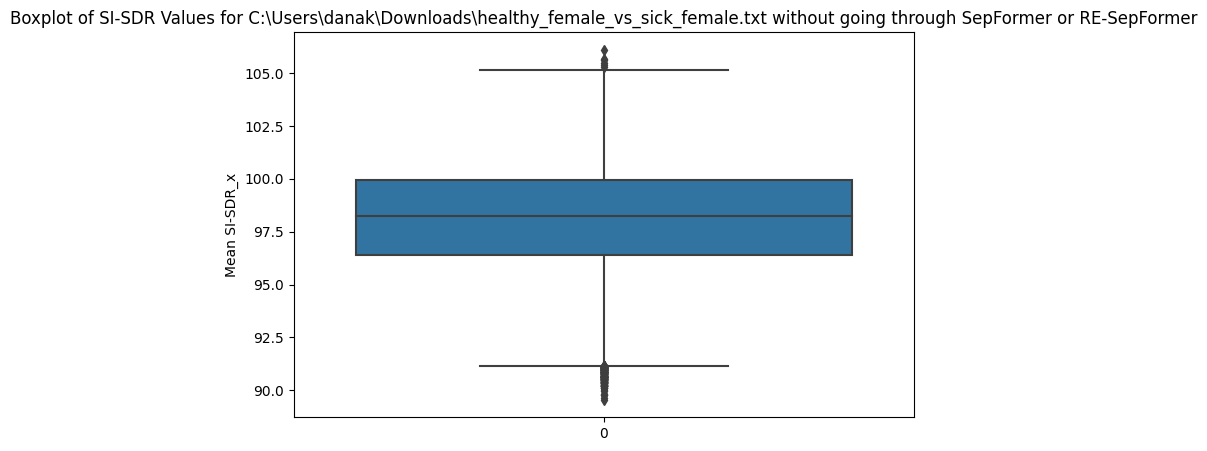

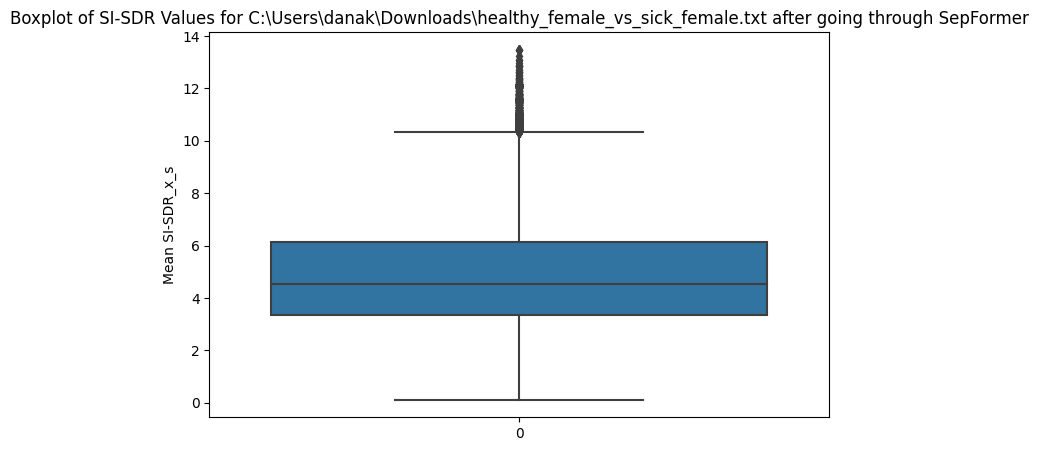

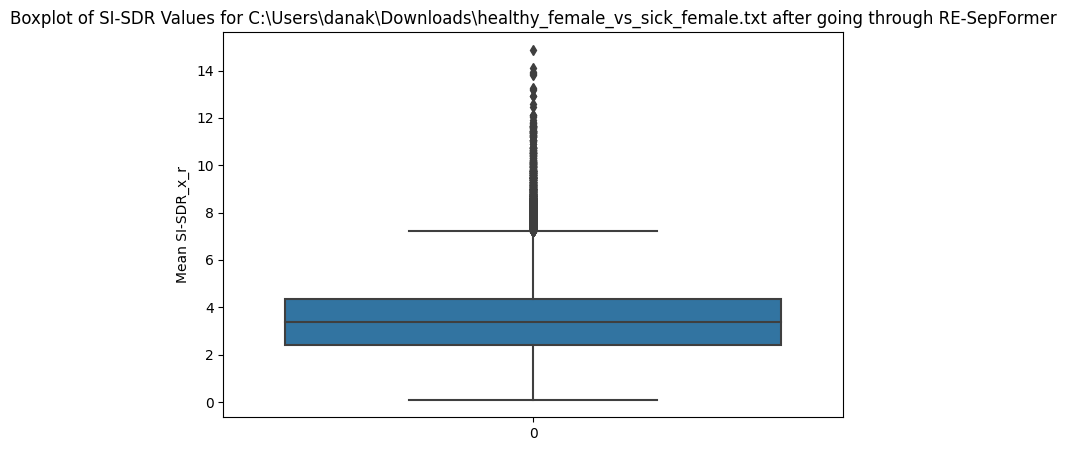

In [27]:

print("Describe the data of mean_SI_SDR_x column")
print(df['mean_SI_SDR_x'].describe())

print("Describe the data of mean_SI_SDR_x_s column")
print(df['mean_SI_SDR_x_s'].describe())

print("Describe the data of mean_SI_SDR_x_r column")
print(df['mean_SI_SDR_x_r'].describe())

# Boxplot of the mean_SI_SDR_x column
plt.figure(figsize=(8, 5))
sns.boxplot(data=df['mean_SI_SDR_x'])
plt.title(f'Boxplot of SI-SDR Values for {scenario_file} without going through SepFormer or RE-SepFormer')
plt.ylabel('Mean SI-SDR_x')
plt.show()

# Boxplot of the mean_SI_SDR_x_s column
plt.figure(figsize=(8, 5))
sns.boxplot(data=df['mean_SI_SDR_x_s'])
plt.title(f'Boxplot of SI-SDR Values for {scenario_file} after going through SepFormer')
plt.ylabel('Mean SI-SDR_x_s')
plt.show()

# Boxplot of the mean_SI_SDR_x_r column
plt.figure(figsize=(8, 5))
sns.boxplot(data=df['mean_SI_SDR_x_r'])
plt.title(f'Boxplot of SI-SDR Values for {scenario_file} after going through RE-SepFormer')
plt.ylabel('Mean SI-SDR_x_r')
plt.show()

# Calculate the mean SI-SDR values
mean_si_sdr_x = df['mean_SI_SDR_x_s'].mean()
mean_si_sdr_x_s = df['mean_SI_SDR_x_s'].mean()
mean_si_sdr_x_r = df['mean_SI_SDR_x_r'].mean()

# Store the mean values in the dictionary
scenario_means[scenario_file] = {'mean_SI_SDR_x': mean_si_sdr_x, 'mean_SI_SDR_x_s': mean_si_sdr_x_s, 'mean_SI_SDR_x_s': mean_si_sdr_x_r}


In [ ]:
# Assume you have a list of scenario filenames
scenario_files = ['scenario1.txt', 'scenario2.txt', 'scenario3.txt']

# Initialize a dictionary to store mean SI-SDR values for each scenario
scenario_means = {}

# Loop through each scenario file and analize it
for scenario_file in scenario_files:
    analysis(scenario_file)

# Create a DataFrame from the mean values
means_df = pd.DataFrame.from_dict(scenario_means, orient='index')

# Plot the mean SI-SDR values
means_df.plot(kind='bar', y=['mean_SI_SDR_x', 'mean_SI_SDR_x_s', 'mean_SI_SDR_x_r'], rot=45, figsize=(10, 6), legend=True)
plt.title('Mean SI-SDR Values for Each Scenario')
plt.xlabel('Scenario')
plt.ylabel('Mean SI-SDR')
plt.show()
    
